In [1]:
import pandas as pd
from sklearn.ensemble import  RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from utils import *


In [2]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


In [3]:
# Read Data
df = pd.read_csv('data/features_3_sec.csv')

In [4]:
# Identify Features and Target Label
y = df['label']
X = df.drop(columns = ['label','filename','length'])

## Untuned model

In [5]:
# Data Spiltting and scaling
X_train_ut, X_test_ut, y_train_ut, y_test_ut = split_scale_data_for_untunned_models(X, y)

print("X_train shape:", X_train_ut.shape)
print("X_test shape:", y_train_ut.shape)


X_train shape: (8991, 57)
X_test shape: (8991,)


In [6]:
# Model Training
model_ut = RandomForestClassifier()
model_ut.fit(X_train_ut, y_train_ut)

RandomForestClassifier()

In [7]:
# Model Testing
y_pred_ut = model_ut.predict(X_test_ut)


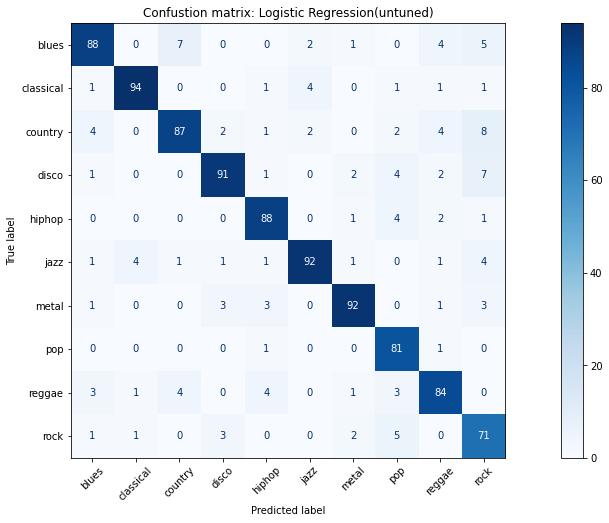

Accuracy : 0.87
Macro F-1 Score : 0.87


In [8]:
# Evaluate Model
class_labels_ut = list(model_ut.classes_)
macro_f1, accuracy = evaluate_models(y_pred_ut, y_test_ut, class_labels_ut, 'Confustion matrix: Logistic Regression(untuned)')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

## Tuned model

In [9]:
## Data Spiltting and scaling

X_train_t, X_val_t, X_test_t, y_train_t, y_val_t, y_test_t = split_scale_data_for_tunned_models(X, y)
print("X_train shape:", X_train_t.shape)
print("X_test shape:", X_test_t.shape)
print("X_val shape:", X_val_t.shape)


X_train shape: (8091, 57)
X_test shape: (999, 57)
X_val shape: (900, 57)


In [10]:
# Setting Hypertunning Using Grid Search
params = {'n_estimators' : [50 , 100, 150, 200]}
grid_t = GridSearchCV(RandomForestClassifier(), params, cv=5, verbose = 10)

# Model Training
grid_t.fit(X_train_ut, y_train_ut)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START n_estimators=50.............................................
[CV 1/5; 1/4] END ..............n_estimators=50;, score=0.853 total time=   1.3s
[CV 2/5; 1/4] START n_estimators=50.............................................
[CV 2/5; 1/4] END ..............n_estimators=50;, score=0.841 total time=   1.3s
[CV 3/5; 1/4] START n_estimators=50.............................................
[CV 3/5; 1/4] END ..............n_estimators=50;, score=0.844 total time=   1.3s
[CV 4/5; 1/4] START n_estimators=50.............................................
[CV 4/5; 1/4] END ..............n_estimators=50;, score=0.855 total time=   1.3s
[CV 5/5; 1/4] START n_estimators=50.............................................
[CV 5/5; 1/4] END ..............n_estimators=50;, score=0.841 total time=   1.3s
[CV 1/5; 2/4] START n_estimators=100............................................
[CV 1/5; 2/4] END .............n_estimators=100;,

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 100, 150, 200]}, verbose=10)

In [11]:
best_model = grid_t.best_estimator_

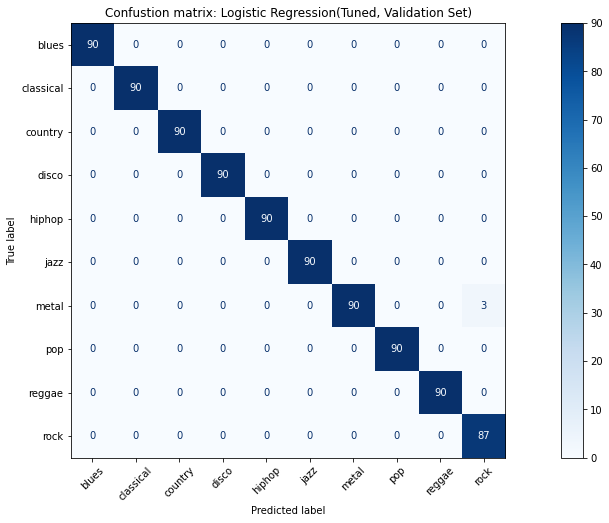

Validation Set Accuracy : 1.00
Validation Set Macro F-1 Score : 1.00


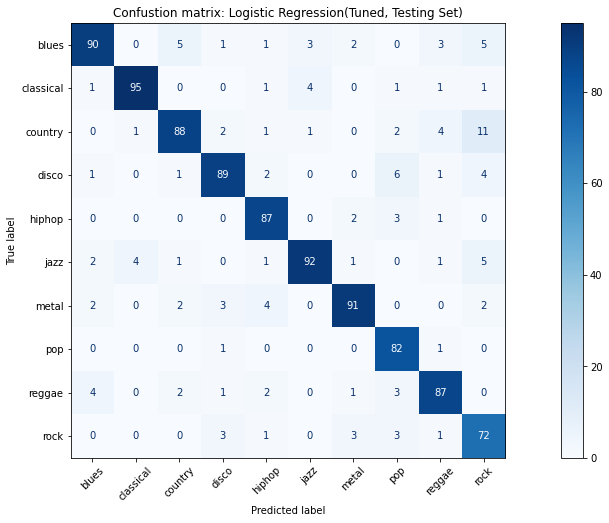

Test Set Accuracy : 0.87
Test Set Macro F-1 Score : 0.87


In [12]:
# Evaluate Model

y_pred_val_t = best_model.predict(X_val_t)
y_pred_test_t = best_model.predict(X_test_t)


class_labels_t = list(best_model.classes_)


macro_f1_val, accuracy_val = evaluate_models(y_pred_val_t, y_val_t, class_labels_t, 'Confustion matrix: Logistic Regression(Tuned, Validation Set)')
print('Validation Set Accuracy : %.2f'%accuracy_val)
print('Validation Set Macro F-1 Score : %.2f'%macro_f1_val)



macro_f1_test, accuracy_test = evaluate_models(y_pred_test_t, y_test_t, class_labels_t, 'Confustion matrix: Logistic Regression(Tuned, Testing Set)')
print('Test Set Accuracy : %.2f'%accuracy_test)
print('Test Set Macro F-1 Score : %.2f'%macro_f1_test)
